In [1]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj statsmodels

In [2]:
import sys
from pathlib import Path

# Calculate the path to the scripts folder relative to the current notebook.
scripts_dir = Path("../../").resolve()

# Add the scripts directory to the sys.path if it's not already there.
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV, cross_val_score

In [46]:
# Carga de datos y preparación inicial
df = pd.read_csv("../../data/processed_data/wells_data_gambia_for_machine_learning.csv")
unique_values = df['DepthToGroundwater'].unique()
value_to_int = {value: idx for idx, value in enumerate(unique_values)}
df['DepthToGroundwater'] = df['DepthToGroundwater'].map(value_to_int)

# Print basic dataset info
print("Total rows in dataset:", len(df))
print('')

# Preparación de los conjuntos de datos
unique_ids = df['ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.15, random_state=42)
train_df = df[df['ID'].isin(train_ids)]
test_df = df[df['ID'].isin(test_ids)]

# Print train-test split details
print("Unique IDs in the dataset:", len(unique_ids))
print("Unique IDs in training set:", len(train_ids))
print("Unique IDs in testing set:", len(test_ids))
print('')
print("Rows in training set:", len(train_df))
print("Rows in testing set:", len(test_df))

X_train = train_df.drop(columns=['GROUNDWATER_LEVEL', 'ID', 'Date'])
y_train = train_df['GROUNDWATER_LEVEL']
X_test = test_df.drop(columns=['GROUNDWATER_LEVEL', 'ID', 'Date'])
y_test = test_df['GROUNDWATER_LEVEL']

# Print shape of train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print('')
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Prepara los grupos para GroupKFold
groups = train_df['ID']


Total rows in dataset: 6636

Unique IDs in the dataset: 36
Unique IDs in training set: 30
Unique IDs in testing set: 6

Rows in training set: 4843
Rows in testing set: 1793
Shape of X_train: (4843, 19)
Shape of y_train: (4843,)

Shape of X_test: (1793, 19)
Shape of y_test: (1793,)


In [42]:
# Define GroupKFold
gkf = GroupKFold(n_splits=5)

# Define the pipeline
pipeline = Pipeline([
    ('nystroem', Nystroem(random_state=1)),
    ('svr', LinearSVR(max_iter=10000, random_state=42, dual='auto'))
])

# Define the parameter grid
param_grid = {
    'nystroem__kernel': ['rbf', 'poly', 'sigmoid'],
    'nystroem__gamma': [0.1, 0.5, 1],
    'nystroem__n_components': [100, 200, 300],
    'svr__C': [0.1, 1, 10]
}

# Grid search with GroupKFold
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Fit the model with groups for the initial grid search
grid_search.fit(X=X_train, y=y_train, groups=groups)

# Best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

Best parameters: {'nystroem__gamma': 0.1, 'nystroem__kernel': 'sigmoid', 'nystroem__n_components': 300, 'svr__C': 10}


In [44]:
# Apply best parameters
nystroem = Nystroem(
    kernel=best_params['nystroem__kernel'],
    gamma=best_params['nystroem__gamma'],
    n_components=best_params['nystroem__n_components'],
    random_state=1
)

linear_svr = LinearSVR(
    C=best_params['svr__C'],
    max_iter=10000,
    random_state=42,
    dual='auto'
)

# Define a new, more focused parameter grid for fine-tuning
param_grid_fine = {
    'nystroem__gamma': [best_params['nystroem__gamma'] * factor for factor in [0.8, 1, 1.2]],
    'svr__C': [best_params['svr__C'] * factor for factor in [0.8, 1, 1.2]]
}

# Update the pipeline with the best parameters
best_model.set_params(**best_params)

# New Grid search for fine-tuning
grid_search_fine = GridSearchCV(
    estimator=best_model,  # Use the best model from the initial grid search
    param_grid=param_grid_fine,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model with groups for the fine-tuning grid search
grid_search_fine.fit(X=X_train, y=y_train, groups=groups)

# Extract new best parameters
new_best_params = grid_search_fine.best_params_
print("New best parameters:", new_best_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
New best parameters: {'nystroem__gamma': 0.08000000000000002, 'svr__C': 10}


In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Tus parámetros seleccionados
final_nystroem = Nystroem(kernel='sigmoid', gamma=0.08, n_components=100, random_state=42)
final_linear_svr = LinearSVR(C=0.12, max_iter=10000, random_state=4, dual='auto')

# Escaladores a probar
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Bucle para probar cada escalador
for scaler in scalers:
    # Definir pipeline con el escalador actual
    pipeline = Pipeline([
        ('scaler', scaler),
        ('nystroem', final_nystroem),
        ('svr', final_linear_svr)
    ])

    # Realizar validación cruzada
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5, groups=groups)

    # Calcular la media y la desviación estándar de los scores
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    # Entrenar el modelo en el conjunto de entrenamiento completo
    pipeline.fit(X_train, y_train)

    # Evaluar en el conjunto de prueba
    test_score = pipeline.score(X_test, y_test)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Imprimir los resultados
    print(f"Resultados para {type(scaler).__name__}:")
    print(f"Media del MSE (Validación Cruzada): {-mean_score}, Desviación estándar: {std_score}")
    print(f"Test Score: {test_score}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Coefficient of Determination (R²): {r2}\n")


Resultados para StandardScaler:
Media del MSE (Validación Cruzada): 22.429579508107548, Desviación estándar: 10.550202303053078
Test Score: 0.5257330223892553
Mean Squared Error (MSE): 7.621690769641141
Mean Absolute Error (MAE): 1.8880354003514868
Coefficient of Determination (R²): 0.5257330223892553

Resultados para MinMaxScaler:
Media del MSE (Validación Cruzada): 58.66237429654636, Desviación estándar: 40.67001421349508
Test Score: 0.06637728878928895
Mean Squared Error (MSE): 15.003750917278294
Mean Absolute Error (MAE): 3.387519792303236
Coefficient of Determination (R²): 0.06637728878928895

Resultados para RobustScaler:
Media del MSE (Validación Cruzada): 38.60402125430317, Desviación estándar: 17.725060722364645
Test Score: -0.4167483495995503
Mean Squared Error (MSE): 22.767804483131663
Mean Absolute Error (MAE): 4.26742719644869
Coefficient of Determination (R²): -0.4167483495995503



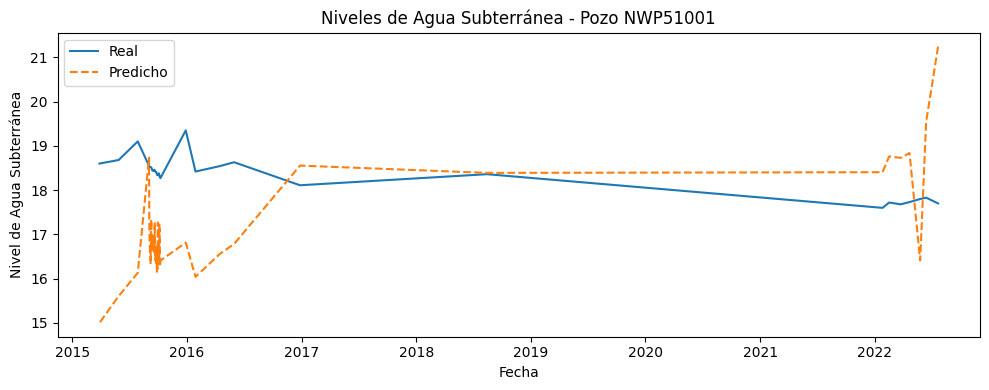

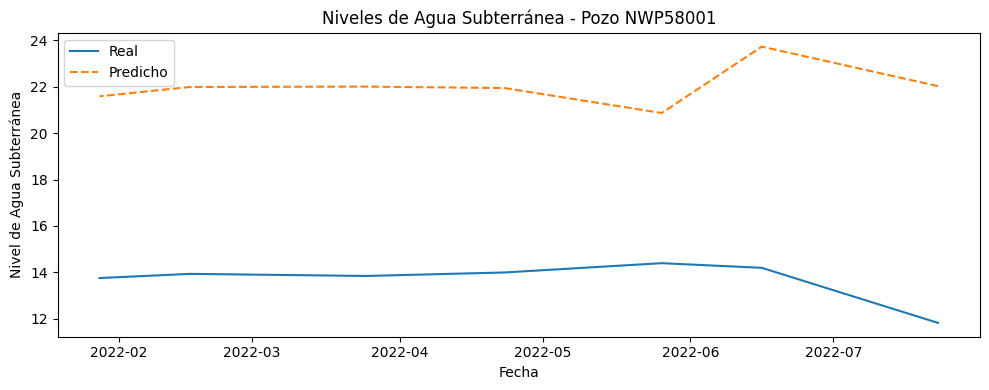

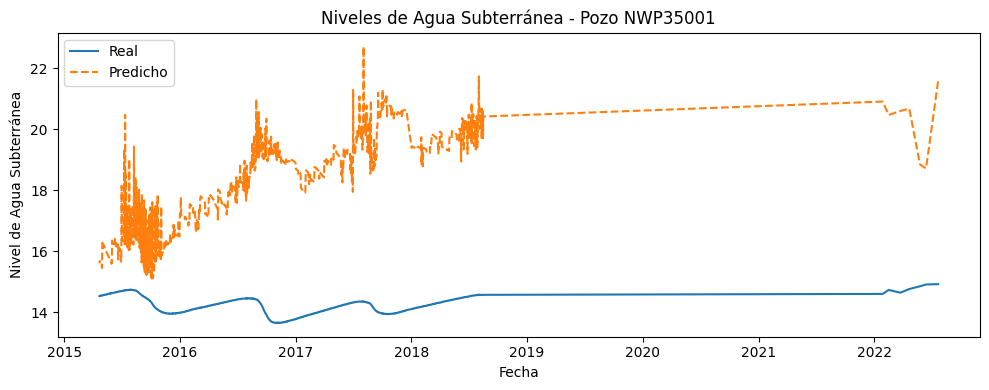

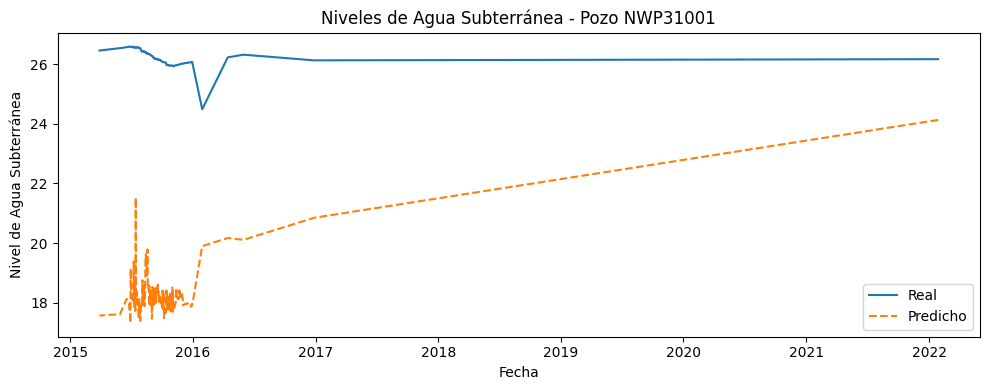

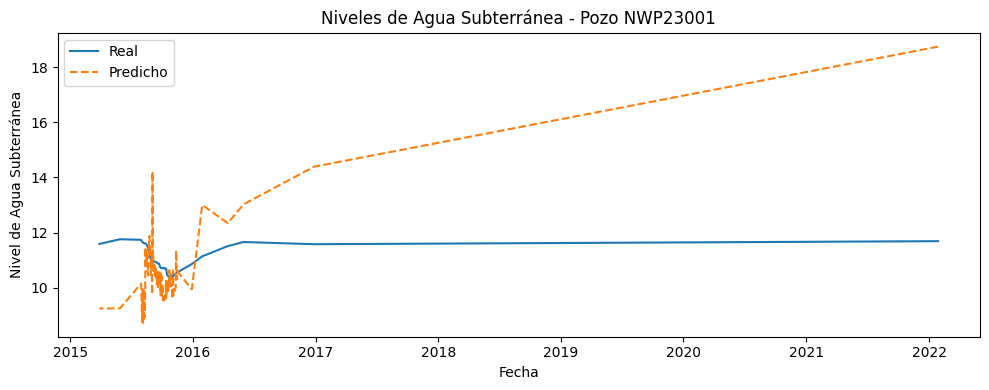

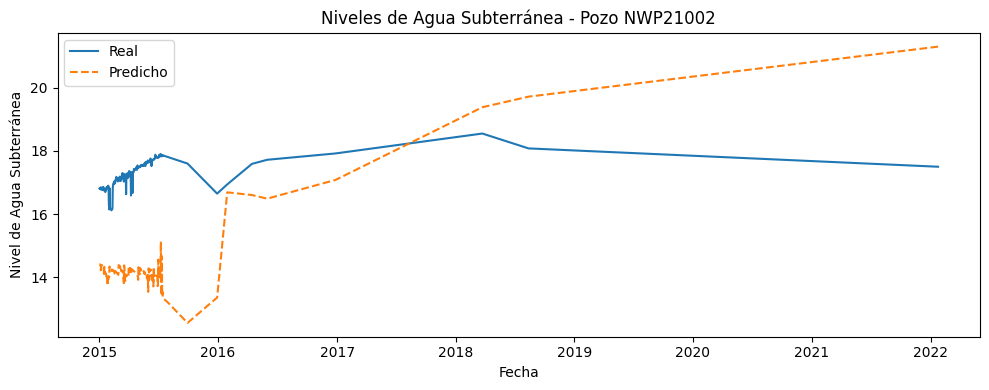

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que las predicciones están alineadas con los índices de test_df
results_df = test_df.copy()
results_df['Predicted'] = predictions  # Asumiendo que 'predictions' está en el mismo orden que 'test_df'

# Crear una columna de fecha a partir de Day, Month, Year
results_df['Date'] = pd.to_datetime(results_df[['Year', 'Month', 'Day']])
results_df.set_index('Date', inplace=True)

# Obtener la lista de IDs únicos de los pozos en el conjunto de prueba
unique_well_ids = results_df['ID'].unique()

# Graficar los resultados para cada ID de pozo
for well_id in unique_well_ids:
    well_data = results_df[results_df['ID'] == well_id]
    
    plt.figure(figsize=(10, 4))
    plt.plot(well_data.index, well_data['GROUNDWATER_LEVEL'], label='Real')
    plt.plot(well_data.index, well_data['Predicted'], label='Predicho', linestyle='--')
    
    plt.title(f"Niveles de Agua Subterránea - Pozo {well_id}")
    plt.xlabel('Fecha')
    plt.ylabel('Nivel de Agua Subterránea')
    plt.legend()
    plt.tight_layout()  # Para asegurar una buena visualización en gráficos múltiples
    plt.show()



In [51]:
df

,ID,GROUNDWATER_LEVEL,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,LIS_Streamflow,...,MOD13Q1_061__250m_16_days_EVI,MOD13Q1_061__250m_16_days_MIR_reflectance,MOD13Q1_061__250m_16_days_NDVI,NASA_IMERG_Late,DepthToGroundwater,Curvatu_tif2,Drainage_density,Slope_tif2,Hydrogeo,NASADEM_HGT
0,NWP00001,14.26,14,4,2016,13.420804,-16.716666,19.47,0.172124,0.059371,...,0.2113,0.3972,0.2564,0.0,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
1,NWP00001,13.82,26,12,2015,13.420804,-16.716666,19.47,0.210837,0.136391,...,0.2443,0.1787,0.4064,1.3,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
2,NWP00001,13.82,25,12,2015,13.420804,-16.716666,19.47,0.211614,0.138738,...,0.2443,0.1787,0.4064,0.0,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
3,NWP00001,13.83,24,12,2015,13.420804,-16.716666,19.47,0.212448,0.141231,...,0.2443,0.1787,0.4064,0.1,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
4,NWP00001,13.83,23,12,2015,13.420804,-16.716666,19.47,0.213260,0.143826,...,0.2443,0.1787,0.4064,0.0,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6631,NWP21002,16.85,5,1,2015,13.240281,-16.713889,21.68,0.232334,0.085506,...,0.1795,0.2054,0.3419,0.5,2,-1.296000e+09,69.201469,2.321531,5.0,25.0
6632,NWP21002,16.79,4,1,2015,13.240281,-16.713889,21.68,0.232903,0.086226,...,0.1795,0.2054,0.3419,0.1,2,-1.296000e+09,69.201469,2.321531,5.0,25.0
6633,NWP21002,16.82,3,1,2015,13.240281,-16.713889,21.68,0.233475,0.086970,...,0.1795,0.2054,0.3419,0.0,2,-1.296000e+09,69.201469,2.321531,5.0,25.0
6634,NWP21002,16.82,2,1,2015,13.240281,-16.713889,21.68,0.234051,0.087731,...,0.1795,0.2054,0.3419,0.0,2,-1.296000e+09,69.201469,2.321531,5.0,25.0


In [52]:
test_df

,ID,GROUNDWATER_LEVEL,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,LIS_Streamflow,...,MOD13Q1_061__250m_16_days_EVI,MOD13Q1_061__250m_16_days_MIR_reflectance,MOD13Q1_061__250m_16_days_NDVI,NASA_IMERG_Late,DepthToGroundwater,Curvatu_tif2,Drainage_density,Slope_tif2,Hydrogeo,NASADEM_HGT
1752,NWP51001,17.70,22,7,2022,13.747787,-15.230825,16.39,0.279089,6.507908,...,0.3193,0.2551,0.4715,68.400002,1,2.592000e+09,112.172928,0.464550,3.0,23.0
1753,NWP51001,17.83,14,6,2022,13.747787,-15.230825,16.39,0.241453,0.075344,...,0.3001,0.1678,0.4356,1.400000,1,2.592000e+09,112.172928,0.464550,3.0,23.0
1754,NWP51001,17.80,26,5,2022,13.747787,-15.230825,16.39,0.204121,0.101228,...,0.1329,0.3787,0.1999,3.000000,1,2.592000e+09,112.172928,0.464550,3.0,23.0
1755,NWP51001,17.73,22,4,2022,13.747787,-15.230825,16.39,0.205304,0.061997,...,0.1547,0.3865,0.2188,0.000000,1,2.592000e+09,112.172928,0.464550,3.0,23.0
1756,NWP51001,17.68,25,3,2022,13.747787,-15.230825,16.39,0.207016,0.069640,...,0.1588,0.3659,0.2299,0.000000,1,2.592000e+09,112.172928,0.464550,3.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6631,NWP21002,16.85,5,1,2015,13.240281,-16.713889,21.68,0.232334,0.085506,...,0.1795,0.2054,0.3419,0.500000,2,-1.296000e+09,69.201469,2.321531,5.0,25.0
6632,NWP21002,16.79,4,1,2015,13.240281,-16.713889,21.68,0.232903,0.086226,...,0.1795,0.2054,0.3419,0.100000,2,-1.296000e+09,69.201469,2.321531,5.0,25.0
6633,NWP21002,16.82,3,1,2015,13.240281,-16.713889,21.68,0.233475,0.086970,...,0.1795,0.2054,0.3419,0.000000,2,-1.296000e+09,69.201469,2.321531,5.0,25.0
6634,NWP21002,16.82,2,1,2015,13.240281,-16.713889,21.68,0.234051,0.087731,...,0.1795,0.2054,0.3419,0.000000,2,-1.296000e+09,69.201469,2.321531,5.0,25.0


In [54]:
train_df

,ID,GROUNDWATER_LEVEL,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,LIS_Streamflow,...,MOD13Q1_061__250m_16_days_EVI,MOD13Q1_061__250m_16_days_MIR_reflectance,MOD13Q1_061__250m_16_days_NDVI,NASA_IMERG_Late,DepthToGroundwater,Curvatu_tif2,Drainage_density,Slope_tif2,Hydrogeo,NASADEM_HGT
0,NWP00001,14.26,14,4,2016,13.420804,-16.716666,19.47,0.172124,0.059371,...,0.2113,0.3972,0.2564,0.0,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
1,NWP00001,13.82,26,12,2015,13.420804,-16.716666,19.47,0.210837,0.136391,...,0.2443,0.1787,0.4064,1.3,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
2,NWP00001,13.82,25,12,2015,13.420804,-16.716666,19.47,0.211614,0.138738,...,0.2443,0.1787,0.4064,0.0,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
3,NWP00001,13.83,24,12,2015,13.420804,-16.716666,19.47,0.212448,0.141231,...,0.2443,0.1787,0.4064,0.1,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
4,NWP00001,13.83,23,12,2015,13.420804,-16.716666,19.47,0.213260,0.143826,...,0.2443,0.1787,0.4064,0.0,0,-6.480000e+09,57.568844,2.785167,5.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6425,NWP33001,24.84,20,6,2015,13.441317,-15.517941,27.39,0.148790,0.000060,...,0.1499,0.2770,0.2361,0.0,1,-2.592000e+09,61.616772,1.914718,3.0,23.0
6426,NWP33001,24.84,19,6,2015,13.441317,-15.517941,27.39,0.148978,0.000046,...,0.1499,0.2770,0.2361,0.0,1,-2.592000e+09,61.616772,1.914718,3.0,23.0
6427,NWP33001,24.83,18,6,2015,13.441317,-15.517941,27.39,0.149151,0.000046,...,0.1499,0.2770,0.2361,0.0,1,-2.592000e+09,61.616772,1.914718,3.0,23.0
6428,NWP33001,24.80,29,5,2015,13.441317,-15.517941,27.39,0.150576,0.000057,...,0.1748,0.3370,0.2549,0.0,1,-2.592000e+09,61.616772,1.914718,3.0,23.0
